# nn-cheatsheet
***notebook showing some best practices that I've stumbled upon in my couple years training emulators - I spent the time so you don't have to ;)***
___

the aim of this notebook is to take you through some clean, efficient ways to train emulators that should save you from making many of the same mistakes that I did! this will include:
- ways to scale the data that might help with training
- a clean method for instantiating a (brute force) gridsearch algorithm of network architectures and hyperparams using `itertools.product`
- ways to name networks in an informative way that avoids overwriting (this will save you a lot of time later on!)
- failsafes to make sure we're saving networks often enough that an OOM error won't lose hours of training, and to make sure we're only saving the best performing weights and biases for a given network

there's likely other stuff I forgot. I'll try to remember to add these later!


In [180]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

## data scaling
usually called *data augmentation* in ML circles, but this can scare astrophysicists!
___
we'll start by generating some dummy data for our networks to learn. let's try to get network to reproduce the functions:

In [173]:
def generate_data(data_range, data_N, seed=42):
    return np.random.uniform(low=-data_range, high=data_range, size=data_N)

data_N = int(1e5)

x3_range = 1
x3 = generate_data(x3_range, data_N)

x2_range = 10
x2 = generate_data(x2_range, data_N)

x1_range = 100
x1 = generate_data(x1_range, data_N)

In [210]:
def y1_function(x1, x2, x3):
    y1 = x1 + 2*(x2**2) + 3*(x3**3)
    return y1

y1 = y1_function(x1, x2, x3)

def y2_function(x1, x2, x3):
    y2 = - x1 - np.e*(x2**np.e) - np.pi*(x3**np.pi)
    return y2

y2 = y2_function(x1, x2, x3)

/tmp/ipykernel_304842/3257225517.py:8: RuntimeWarning: invalid value encountered in power
  y2 = -x1 - np.e*(x2**np.e) - np.pi*(x3**np.pi)


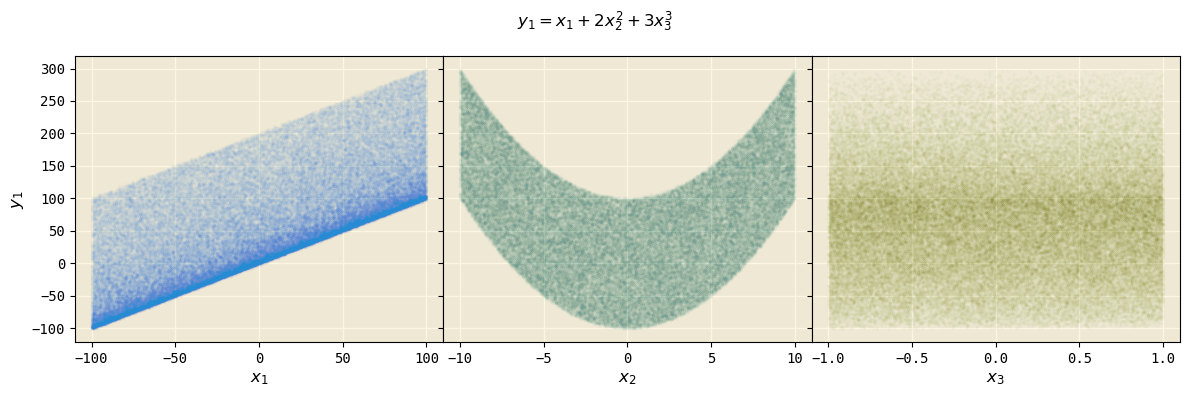

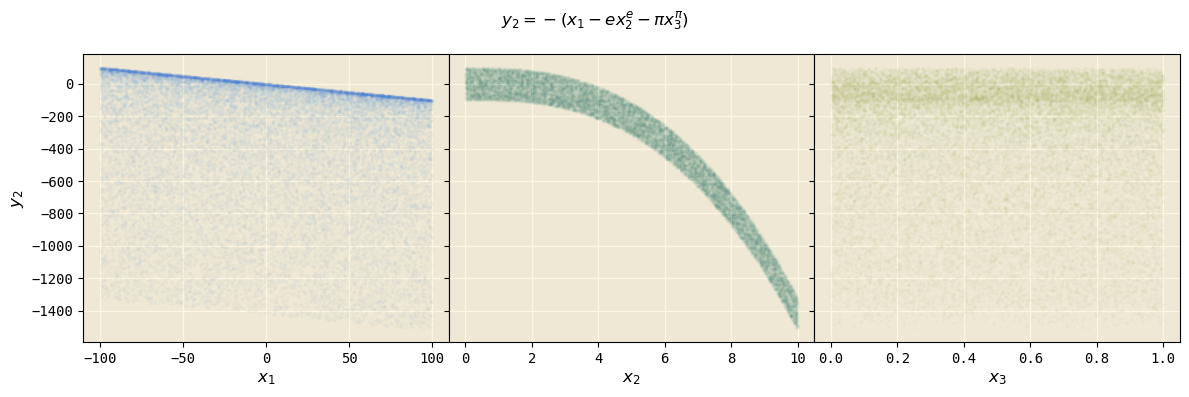

In [213]:
def input_plots(x1, x2, x3, y, alpha=0.01, s=3, ylabel = None, title=None):
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,4))

    colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    ax1.scatter(x1, y, alpha=alpha,s=s, c=colours[0])
    ax1.set_ylabel(ylabel)
    ax1.set_xlabel(r'$x_1$')

    ax2.scatter(x2, y, alpha=alpha,s=s, c=colours[1])
    ax2.yaxis.set_tick_params(labelleft=False)
    ax2.set_xlabel(r'$x_2$')
    
    ax3.scatter(x3, y, alpha=alpha,s=s, c=colours[2])
    ax3.yaxis.set_tick_params(labelleft=False)
    ax3.set_xlabel(r'$x_3$')

    plt.suptitle(title)
    plt.tight_layout()
    fig.subplots_adjust(wspace=0)
    fig.patch.set_alpha(0.0)
    plt.show()

input_plots(x1,x2,x3,y1, ylabel = r'$y_1$', title=r'$y_1 = x_1 + 2x_{2}^2 + 3x_{3}^3$')
input_plots(x1,x2,x3,y2, ylabel = r'$y_2$', title=r'$y_2 = - (x_1 - ex_{2}^e - \pi x_{3}^\pi)$')

In [216]:
dataset_df = pd.DataFrame(
    {
        "x1" : x1,
        "x2" : x2,
        "x3" : x3,
        "y1" : y1,
        "y2" : y2
    }
)
dataset_df.describe()

,x1,x2,x3,y1,y2
count,100000.000000,100000.000000,100000.000000,100000.000000,24946.000000
mean,0.220332,0.002689,-0.001146,66.989306,-381.346223
std,57.750376,5.777936,0.578097,82.969595,410.988805
min,-99.997961,-9.999806,-0.999985,-101.271010,-1512.307556
25%,-49.957976,-5.009371,-0.505767,4.311436,-648.580497
50%,0.176601,0.015499,-0.003725,65.355783,-221.642962
75%,50.392925,5.023652,0.501006,121.497391,-57.439106
max,99.998607,9.999886,0.999995,298.694429,99.516529
